In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from functions import q_drydown, exponential_drydown, q_loss

In [2]:
dir_name = f"fit_models_py_raraki_2023-10-26_CONUS"

# Read data

In [3]:
input_file = rf"/home/raraki/waves/projects/smap-drydown/output/{dir_name}/all_results.csv"
_df = pd.read_csv(input_file)
coord_info_file = "/home/raraki/waves/projects/smap-drydown/data/datarods/coord_info.csv"
coord_info = pd.read_csv(coord_info_file)
df = _df.merge(coord_info, on=['EASE_row_index', 'EASE_column_index'], how='left')
print(f"Number of events: {len(df)}")
df.head()

Number of events: 103118


,Unnamed: 0,EASE_row_index,EASE_column_index,event_start,event_end,time,sm,min_sm,max_sm,pet,...,exp_r_squared,exp_y_opt,q_k,q_q,q_delta_theta,q_r_squared,q_y_opt,id,latitude,longitude
0,0,49,178,2015-07-06,2015-07-16,[ 0 1 2 4 5 7 8 9 10],[0.2700876 0.23557265 0.21525141 0.1968715 0...,0.075926,0.328024,4.546666,...,0.975346,"[0.26412165493388085, 0.24139738415785048, 0.2...",0.202903,1.918047e+00,0.755568,0.977789,"[0.26640344948855904, 0.2404375016771953, 0.22...",47414,49.00465,-113.34025
1,1,49,178,2015-07-18,2015-07-22,[0 1 3 4],[0.25743487 0.21624508 0.23729874 0.21127926],0.075926,0.328024,4.690045,...,0.499637,"[0.2572866811355069, 0.21781057269789478, 0.21...",4.690045,9.900271e+00,0.705167,0.514283,"[0.25369743783879695, 0.2338783111456459, 0.21...",47414,49.00465,-113.34025
2,2,49,178,2016-10-16,2016-10-27,[ 0 1 3 4 5 6 8 9 11],[0.27266908 0.23120848 0.23455536 0.23573506 0...,0.075926,0.328024,1.012646,...,0.760390,"[0.2602228482451473, 0.2502020562923525, 0.235...",1.012646,8.347464e+00,0.751935,0.813172,"[0.26548764589419876, 0.2494341356425815, 0.23...",47414,49.00465,-113.34025
3,3,49,178,2017-09-14,2017-09-22,[0 1 3 4 6 7 8],[0.20092689 0.17785274 0.19096084 0.17382596 0...,0.075926,0.328024,1.716990,...,0.617091,"[0.2030338659424098, 0.19249319777760432, 0.17...",0.034580,3.394039e-13,0.504964,0.675996,"[0.2032265298566947, 0.19450887316881393, 0.17...",47414,49.00465,-113.34025
4,4,49,178,2019-04-04,2019-04-09,[0 1 2 4 5],[0.26918507 0.2656639 0.25493159 0.26055649 0...,0.075926,0.328024,1.790631,...,0.691905,"[0.26906007192877474, 0.26413883069662036, 0.2...",0.016283,2.124995e-09,0.764159,0.698771,"[0.2685692772512031, 0.26446439047231707, 0.26...",47414,49.00465,-113.34025


In [15]:
print(df[df["q_r_squared"]>df["exp_r_squared"]].index)

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 9,     11,
            ...
            103104, 103105, 103106, 103107, 103108, 103112, 103113, 103114,
            103115, 103117],
           dtype='int64', length=72125)


In [106]:
event_id = 9

In [107]:
event = df.loc[event_id]

In [108]:
# Your input string
input_string =event.sm

# Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
input_string = input_string.replace('\n', ' np.nan')

# Replace ' nan' with ' np.nan' (with a space before np.nan) to ensure it's a valid NumPy nan value
input_string = input_string.replace(' nan', ' np.nan')

# Remove the square brackets at the beginning and end of the string
input_string = input_string.strip('[]')

# Convert the modified string to a NumPy array
sm = np.array([float(value) if value != 'np.nan' else np.nan for value in input_string.split()])
sm

array([0.24183768, 0.20831373, 0.16579126, 0.1471386 , 0.20398675,
       0.19658515,        nan, 0.16578399])

In [109]:


# Your input string

# Remove the square brackets and split the string into individual values
values = event.time.strip('[]').split()

# Convert the values to integers and create a NumPy array
t_d = np.array([int(value) for value in values])
t_d


array([ 0,  1,  5,  6,  8,  9, 11])

In [110]:
import ast
def string_to_numpy_array(string):
    try:
        # Use ast.literal_eval to safely evaluate the string as a list
        return np.array(ast.literal_eval(string))
    except (SyntaxError, ValueError):
        return np.nan  # Return NaN if the string cannot be converted


In [111]:
n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days
n_days

11

In [112]:
# Define variables 
theta = np.arange(0, 1, 0.01)
t = np.arange(0, n_days+1, 0.1)
# t_d = np.array([float(value) if value != 'np.nan' else np.nan for value in event.time.split()])
# t_h = pd.date_range(start=event.event_start, end=event.event_end, freq="H")

# Define parameters
k= event.q_k
q0 = 1
q = event.q_q
delta_theta = event.q_delta_theta
# q2 = 0.7
min_sm = event.min_sm
max_sm = event.max_sm

_exp_y_opt = np.array(ast.literal_eval(event.exp_y_opt)) # df['exp_y_opt'].apply(string_to_numpy_array)
exp_y_opt = (_exp_y_opt - min_sm)/(max_sm - min_sm)
_q_y_opt = np.array(ast.literal_eval(event.q_y_opt)) # df['q_y_opt'].apply(string_to_numpy_array)
q_y_opt = (_q_y_opt - min_sm)/(max_sm - min_sm)

exp_delta_theta = event.exp_delta_theta
theta_w = event.exp_theta_w
tau = event.exp_tau

norm_sm =  (sm-min_sm)/(max_sm-min_sm)


In [113]:
t_d

array([ 0,  1,  5,  6,  8,  9, 11])

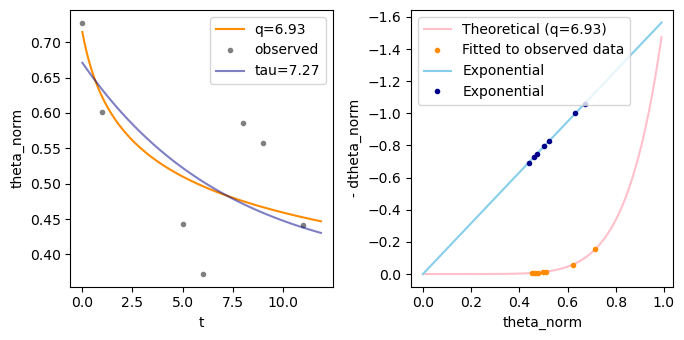

In [114]:
fig = plt.figure(figsize=(7,3.5))

# Calculate & plot the drawdown
ax1 = fig.add_subplot(1,2,1)

# Exponential decay
# ax2.plot(t, q_model(t=t, k=k), '.', label=f'q={q0}')

# Calculated drydown model
# ax2.plot(t, q_y_opt, '.', label=f'q={q1}')
ax1.plot(t, q_drydown(t=t, k=k, q=q, delta_theta=delta_theta), label=f'q={q:.2f}', color='darkorange')
# ax1.plot(t_d, q_y_opt,  '.', color='darkorange')
ax1.plot(t_d, norm_sm[~np.isnan(norm_sm)],  '.', color='gray', label='observed')
_exp = exponential_drydown(t, exp_delta_theta, theta_w, tau)
ax1.plot(t, (_exp-min_sm)/(max_sm - min_sm), label=f'tau={tau:.2f}', color='darkblue', alpha=0.5)
# ax1.plot(t_d, exp_y_opt, '.',  color='darkblue', alpha=0.5)
ax1.set_xlabel("t")
ax1.set_ylabel("theta_norm")
ax1.legend()
# ax2.set_ylim([0., 1])

# # Calculate & plot d_theta
d_theta = loss_model(theta, q, k, theta_wp=0., theta_star=1.)
d_theta_obs = loss_model(q_y_opt, q, k, theta_wp=0., theta_star=1.)
d_theta_exp = loss_model(theta, q=1, k=k, theta_wp=0., theta_star=1.)
d_theta_obs_exp = loss_model(exp_y_opt, q=1, k=k, theta_wp=0., theta_star=1.)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(theta, d_theta, label=f'Theoretical (q={q:.2f})', color='pink')
ax2.plot(q_y_opt, d_theta_obs, '.', label=f'Fitted to observed data', color='darkorange')
ax2.plot(theta, loss_model(theta, q=1, k=k), label=f'Exponential', color='skyblue')
ax2.plot(exp_y_opt, d_theta_obs_exp, '.', label=f'Exponential', color='darkblue')
ax2.set_xlabel("theta_norm")
ax2.set_ylabel("- dtheta_norm")
ax2.invert_yaxis()
ax2.legend()

fig.tight_layout()

NameError: name 'vegetation_order' is not defined